In [1]:
import torch
from torch import nn
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import os
from sklearn.model_selection import train_test_split
from torch.utils.data import Dataset, DataLoader
from transformers.modeling_outputs import Seq2SeqLMOutput
from transformers import GenerationConfig
from torch.optim import AdamW
from tqdm import tqdm
import datetime

from models.trocr_apl import TrocrApl
from dataset.dataset import HandwrittenTextDataset



/dcs/20/u2034788/.local/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:


print("Defining Constants")

DEVICE: str = "cuda" if torch.cuda.is_available() else "cpu"
CSV_SEPERATOR: str = "🫤"
MAX_STRING_LENGTH: int = 128
EARLY_STOPPING: bool = True
BEAM_WIDTH: int = 5
BATCH_SIZE: int = 2
LENGTH_PENALTY: float = 2.0
NO_REPEAT_NGRAM: int = 2
START_EPOCH: int = 16



Defining Constants


In [3]:

print("Defining Paths")
#file_dirpath: str = os.path.abspath(os.path.dirname(__file__)) 
file_dirpath: str = os.path.abspath(".") # (Jupyter)
root_dirpath: str = os.path.join(
    file_dirpath,
    os.pardir
)
dataset_dirpath: str = os.path.join(
    root_dirpath,
    "dataset"
)
apl_dataset_dirpath: str = os.path.join(
    dataset_dirpath,
    "apl_dataset"
)
metadata_csv_filepath: str = os.path.join(
    dataset_dirpath,
    "metadata_apl_fix.csv"
)
load_checkpoint_dirpath: str = os.path.join(
   root_dirpath,
   "models",
   "trocr" 
)
save_checkpoint_dirpath: str = os.path.join(
   root_dirpath,
   "models",
   "trained_trocr" 
) 
#load_checkpoint_dirpath: str = "microsoft/trocr-base-stage1"

#os.makedirs(checkpoint_dirpath, exist_ok=True)

log_dirpath: str = os.path.join(
    root_dirpath,
    "logs"
)
os.makedirs(log_dirpath, exist_ok=True)



Defining Paths


In [4]:

def log(
    string: str,
    filename: str = "log.txt",
    max_length: int = 100000
) -> None:
    
    log_filepath: str = os.path.join(
        log_dirpath,
        filename
    )
    
    formatted_string: str = f"{datetime.datetime.now()}{CSV_SEPERATOR}{string}\n"
    
    with open(log_filepath, "a") as f:
        f.write(formatted_string)





In [5]:


print("Loading Model")

encoder_train_layers: list[str] = [
    'encoder.pooler.dense.bias', 
    'encoder.pooler.dense.weight'
]

trocr_model: TrocrApl = TrocrApl(
    max_target_length=128,
    model_checkpoint_path=load_checkpoint_dirpath,
    apl_tokeniser_path=load_checkpoint_dirpath
)

trocr_model.model.save_pretrained(save_checkpoint_dirpath)
trocr_model.processor.save_pretrained(save_checkpoint_dirpath)

for name, param in trocr_model.model.named_parameters():
    print(name)
    if name.startswith("encoder") and not any(layer in name for layer in encoder_train_layers):
        param.requires_grad = False


Loading Model


Config of the encoder: <class 'transformers.models.vit.modeling_vit.ViTModel'> is overwritten by shared encoder config: ViTConfig {
  "attention_probs_dropout_prob": 0.0,
  "encoder_stride": 16,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.0,
  "hidden_size": 768,
  "image_size": 384,
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "layer_norm_eps": 1e-12,
  "model_type": "vit",
  "num_attention_heads": 12,
  "num_channels": 3,
  "num_hidden_layers": 12,
  "patch_size": 16,
  "qkv_bias": false,
  "transformers_version": "4.46.3"
}

Config of the decoder: <class 'transformers.models.trocr.modeling_trocr.TrOCRForCausalLM'> is overwritten by shared decoder config: TrOCRConfig {
  "activation_dropout": 0.1,
  "activation_function": "relu",
  "add_cross_attention": true,
  "attention_dropout": 0.0,
  "bos_token_id": 0,
  "classifier_dropout": 0.0,
  "cross_attention_hidden_size": 768,
  "d_model": 1024,
  "decoder_attention_heads": 16,
  "decoder_ffn_dim": 4096,
  "decoder

encoder.embeddings.cls_token
encoder.embeddings.position_embeddings
encoder.embeddings.patch_embeddings.projection.weight
encoder.embeddings.patch_embeddings.projection.bias
encoder.encoder.layer.0.attention.attention.query.weight
encoder.encoder.layer.0.attention.attention.key.weight
encoder.encoder.layer.0.attention.attention.value.weight
encoder.encoder.layer.0.attention.output.dense.weight
encoder.encoder.layer.0.attention.output.dense.bias
encoder.encoder.layer.0.intermediate.dense.weight
encoder.encoder.layer.0.intermediate.dense.bias
encoder.encoder.layer.0.output.dense.weight
encoder.encoder.layer.0.output.dense.bias
encoder.encoder.layer.0.layernorm_before.weight
encoder.encoder.layer.0.layernorm_before.bias
encoder.encoder.layer.0.layernorm_after.weight
encoder.encoder.layer.0.layernorm_after.bias
encoder.encoder.layer.1.attention.attention.query.weight
encoder.encoder.layer.1.attention.attention.key.weight
encoder.encoder.layer.1.attention.attention.value.weight
encoder.enco

In [6]:





print("Loading MetaData")

metadata_df: pd.DataFrame = pd.read_csv(
    metadata_csv_filepath,
    delimiter=CSV_SEPERATOR,
    encoding="utf-8",
    engine="python"
)
filenames: list[str] = metadata_df["filename"].to_list()
labels: list[str] = metadata_df["label"].to_list()




Loading MetaData


In [7]:


print("Splitting dataset")


train_filenames: list[str] = []
val_filenames: list[str] = []
train_labels: list[str] = []
val_labels: list[str] = []

train_filenames, val_filenames, train_labels, val_labels = train_test_split(
    filenames, 
    labels,
    train_size=0.99
)




Splitting dataset


In [8]:
import torch
import torch.nn.functional as F

def custom_collate_fn(batch):
    """
    Custom collate function to ensure all images in the batch have the same shape.
    If shapes differ, images are resized to match the largest (y, x) dimensions in the batch.
    
    Args:
        batch (list of tuples): A list where each tuple contains an image tensor (1, y, x)
                                and optionally, its corresponding label or metadata.
                                
    Returns:
        Tuple: Batch of images (tensor) and labels (if any).
    """
    # Separate images and labels (if any)
    images, labels = zip(*batch) if isinstance(batch[0], (tuple, list)) else (batch, None)

    # Determine the maximum height and width in the batch
    max_y = 400# max(img.shape[1] for img in images)
    max_x = max(img.shape[2] for img in images)

    # Resize images to the largest dimensions
    resized_images = []
    for img in images:
        if img.shape[1] != max_y or img.shape[2] != max_x:
            # Resize to (1, max_y, max_x) while keeping the batch and channel dimensions
            resized_img = F.interpolate(
                img.unsqueeze(0),  # Add batch dimension
                size=(max_y, max_x),
                mode='bilinear',
                align_corners=False
            ).squeeze(0)
            
            resized_images.append(resized_img)
            
            print("Weird shape!")
            print(img)
            print(img.shape)
            
        else:
            resized_images.append(img)
    
    # Stack resized images into a single tensor
    batch_images = torch.stack(resized_images, dim=0)

    # Return the batch of images and labels (if labels exist)
    if labels is not None:
        return batch_images, torch.stack(labels, dim=0)
    return batch_images


In [9]:


print("Loading Datasets")


train_dataset: HandwrittenTextDataset = HandwrittenTextDataset(
    dataset_dirpath=apl_dataset_dirpath,
    filenames=train_filenames,#[250*2:265*2],
    label_strings=train_labels,#[250*2:265*2],
    processor=trocr_model.processor,
    max_target_length=MAX_STRING_LENGTH
)
val_dataset: HandwrittenTextDataset = HandwrittenTextDataset(
    dataset_dirpath=apl_dataset_dirpath,
    filenames=val_filenames,
    label_strings=val_labels,
    processor=trocr_model.processor,
    max_target_length=MAX_STRING_LENGTH
)

train_dataloader: DataLoader = DataLoader(
    dataset=train_dataset,
    batch_size=BATCH_SIZE,
    shuffle=False,
    collate_fn=custom_collate_fn
)

val_dataloader: DataLoader = DataLoader(
    dataset=val_dataset,
    batch_size=BATCH_SIZE,
    shuffle=False,
    collate_fn=custom_collate_fn
)

Loading Datasets


In [10]:
train_dataset.filepaths

['/dcs/20/u2034788/Documents/Project/ocr-model-training/src/../dataset/apl_dataset/1732160505.3065627.png',
 '/dcs/20/u2034788/Documents/Project/ocr-model-training/src/../dataset/apl_dataset/1732156602.210982.png',
 '/dcs/20/u2034788/Documents/Project/ocr-model-training/src/../dataset/apl_dataset/1732293421.4629993.png',
 '/dcs/20/u2034788/Documents/Project/ocr-model-training/src/../dataset/apl_dataset/1732144060.3375502.png',
 '/dcs/20/u2034788/Documents/Project/ocr-model-training/src/../dataset/apl_dataset/1732144835.3296773.png',
 '/dcs/20/u2034788/Documents/Project/ocr-model-training/src/../dataset/apl_dataset/1732146919.6309614.png',
 '/dcs/20/u2034788/Documents/Project/ocr-model-training/src/../dataset/apl_dataset/1732295099.756722.png',
 '/dcs/20/u2034788/Documents/Project/ocr-model-training/src/../dataset/apl_dataset/1732143356.220302.png',
 '/dcs/20/u2034788/Documents/Project/ocr-model-training/src/../dataset/apl_dataset/1732147070.6569264.png',
 '/dcs/20/u2034788/Documents/Pr

In [11]:
import matplotlib.pyplot as plt

iter:   0%|          | 0/25241 [00:00<?, ?it/s]

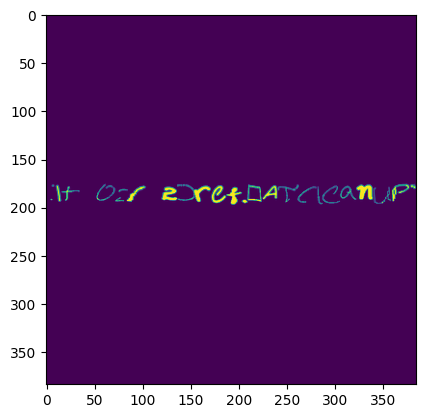

iter:   0%|          | 1/25241 [00:02<14:41:25,  2.10s/it]

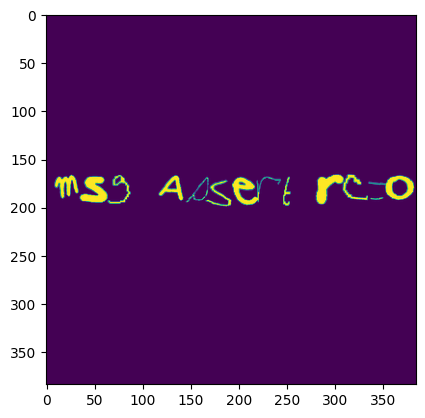

iter:   0%|          | 2/25241 [00:04<14:35:45,  2.08s/it]

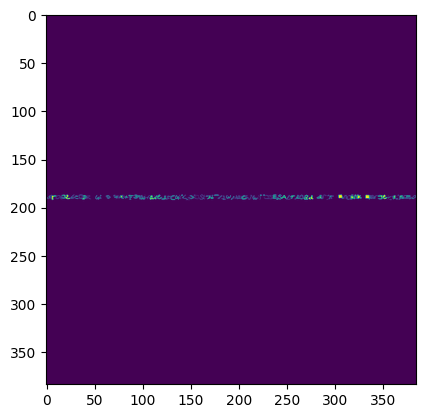

iter:   0%|          | 3/25241 [00:06<14:38:39,  2.09s/it]

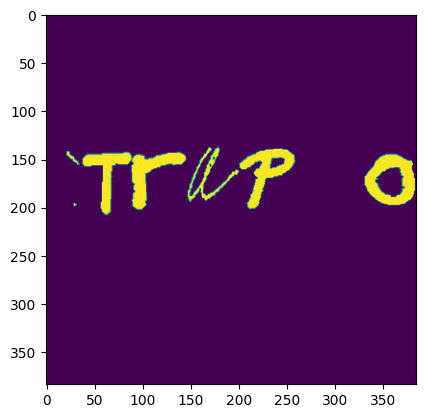

iter:   0%|          | 4/25241 [00:08<14:35:32,  2.08s/it]

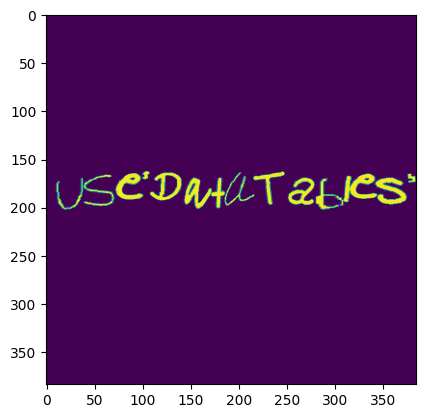

iter:   0%|          | 5/25241 [00:10<14:34:03,  2.08s/it]

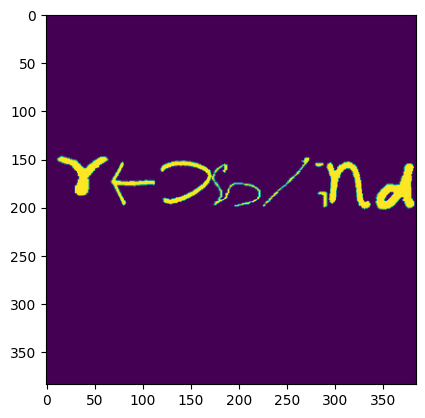

iter:   0%|          | 6/25241 [00:12<14:33:00,  2.08s/it]

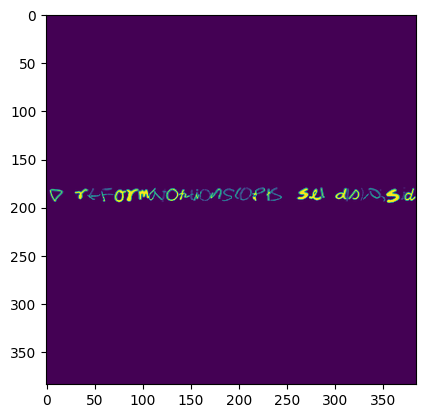

iter:   0%|          | 7/25241 [00:14<14:33:17,  2.08s/it]

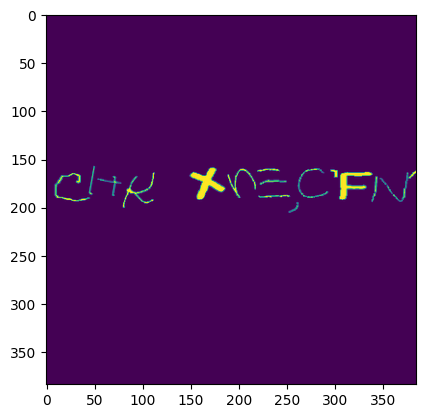

iter:   0%|          | 8/25241 [00:16<14:32:23,  2.07s/it]

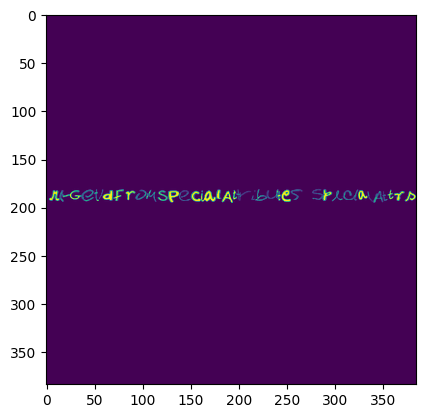

iter:   0%|          | 9/25241 [00:18<14:50:44,  2.12s/it]

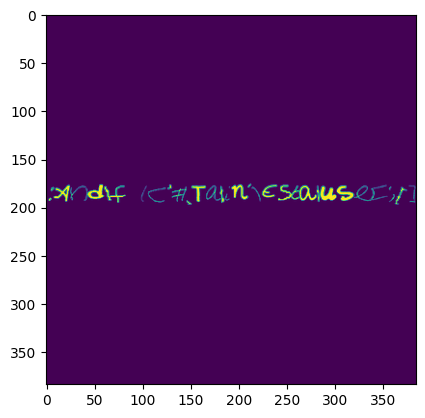

iter:   0%|          | 10/25241 [00:20<14:44:57,  2.10s/it]

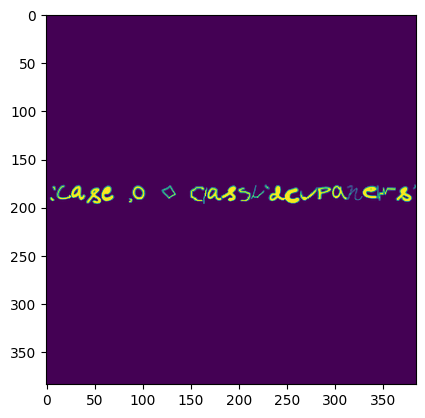

iter:   0%|          | 11/25241 [00:22<14:41:19,  2.10s/it]

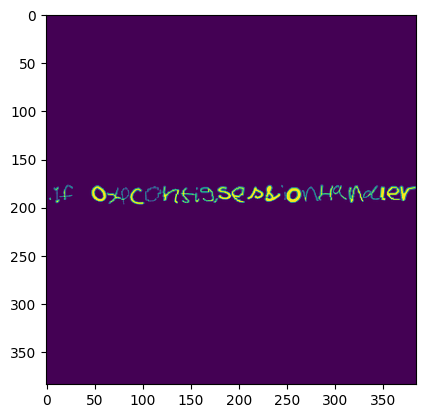

iter:   0%|          | 12/25241 [00:25<14:38:31,  2.09s/it]

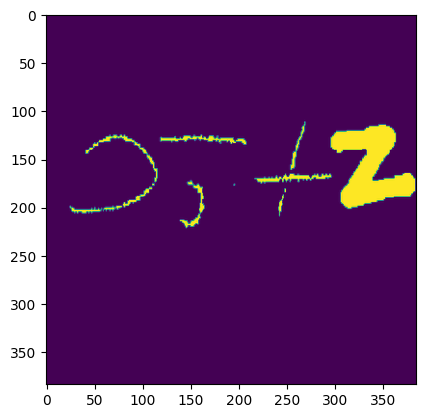

iter:   0%|          | 13/25241 [00:27<14:35:54,  2.08s/it]

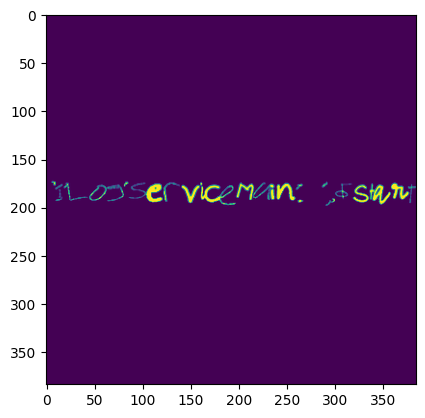

iter:   0%|          | 14/25241 [00:29<14:34:49,  2.08s/it]

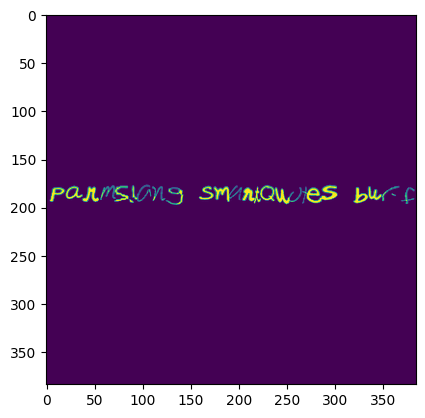

iter:   0%|          | 15/25241 [00:31<14:34:05,  2.08s/it]

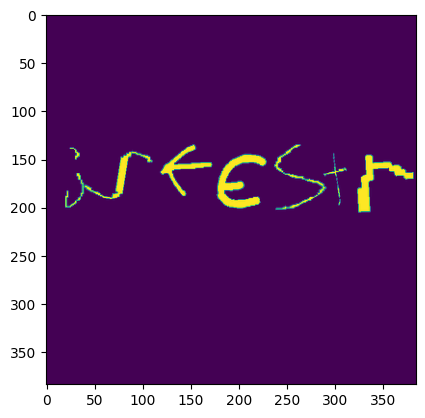

iter:   0%|          | 16/25241 [00:33<14:32:50,  2.08s/it]

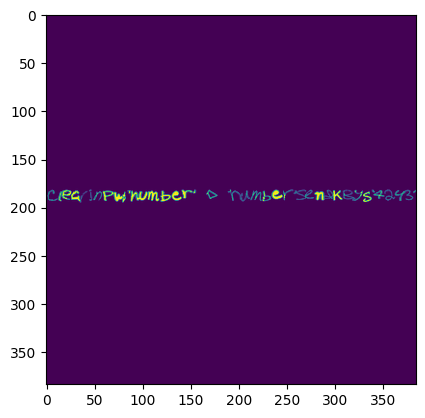

iter:   0%|          | 17/25241 [00:35<14:33:05,  2.08s/it]

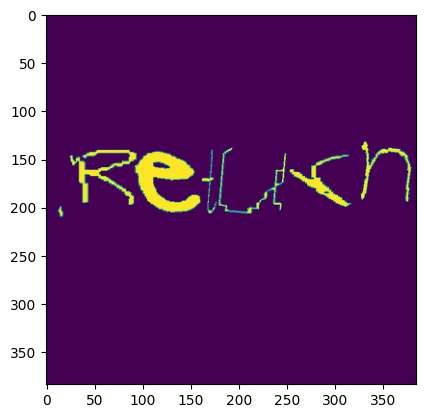

iter:   0%|          | 18/25241 [00:37<14:32:04,  2.07s/it]

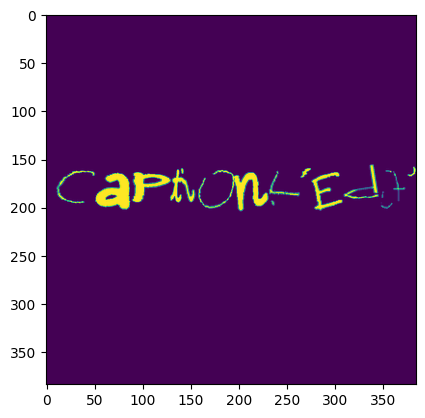

iter:   0%|          | 19/25241 [00:39<14:31:35,  2.07s/it]

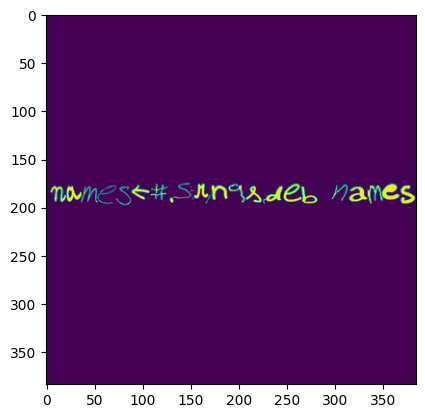

iter:   0%|          | 20/25241 [00:41<14:31:36,  2.07s/it]

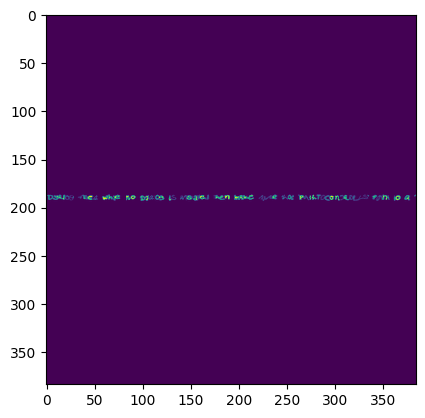

iter:   0%|          | 21/25241 [00:43<14:33:56,  2.08s/it]

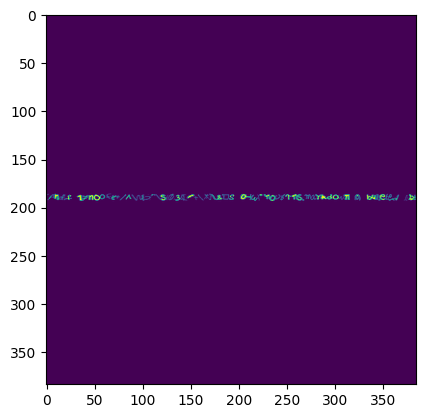

iter:   0%|          | 22/25241 [00:45<14:34:54,  2.08s/it]

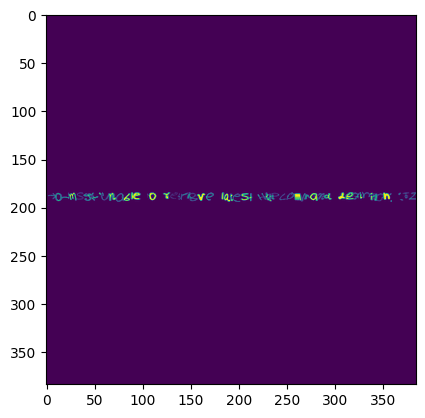

iter:   0%|          | 23/25241 [00:47<14:35:05,  2.08s/it]

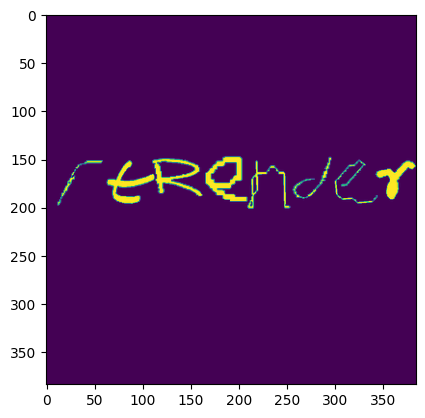

iter:   0%|          | 24/25241 [00:49<14:33:44,  2.08s/it]

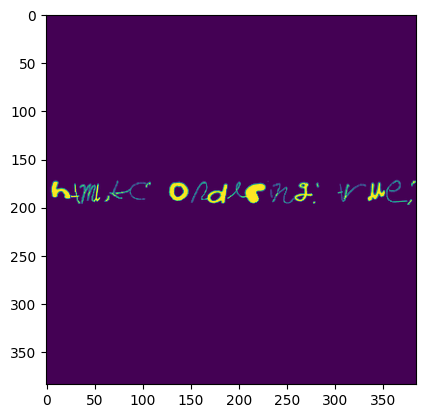

iter:   0%|          | 25/25241 [00:52<14:32:51,  2.08s/it]

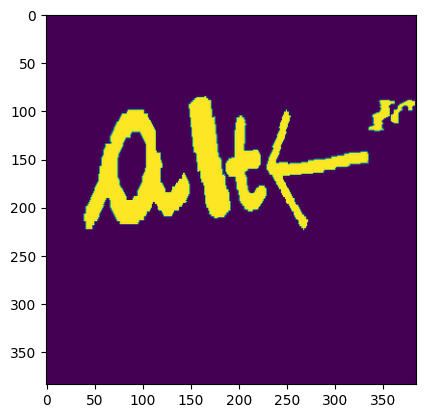

iter:   0%|          | 26/25241 [00:54<14:31:36,  2.07s/it]

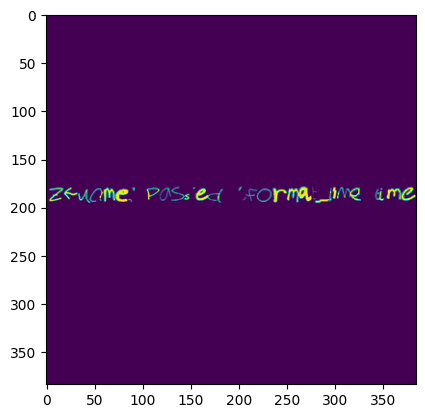

iter:   0%|          | 27/25241 [00:56<14:31:46,  2.07s/it]

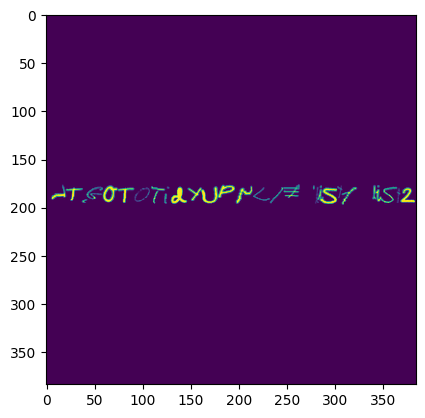

iter:   0%|          | 28/25241 [00:58<14:31:33,  2.07s/it]

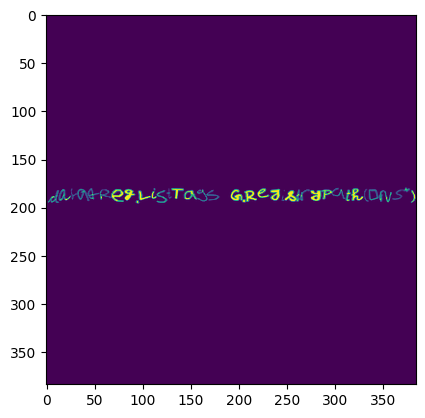

iter:   0%|          | 29/25241 [01:00<14:31:53,  2.07s/it]

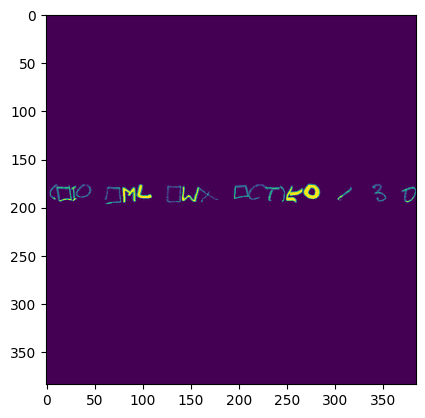

iter:   0%|          | 30/25241 [01:02<14:31:52,  2.08s/it]

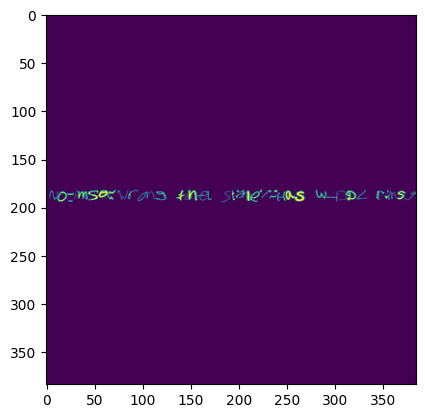

iter:   0%|          | 31/25241 [01:04<14:32:18,  2.08s/it]

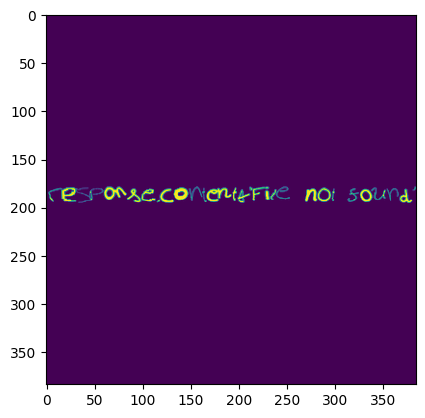

iter:   0%|          | 32/25241 [01:06<14:32:08,  2.08s/it]

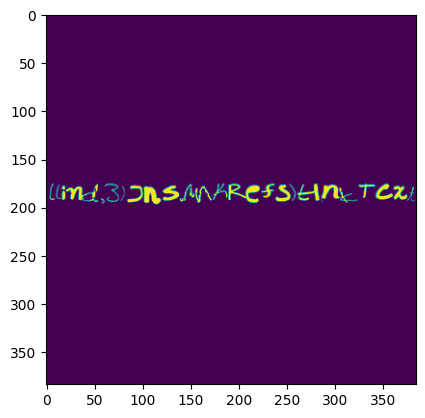

iter:   0%|          | 33/25241 [01:08<14:31:54,  2.08s/it]

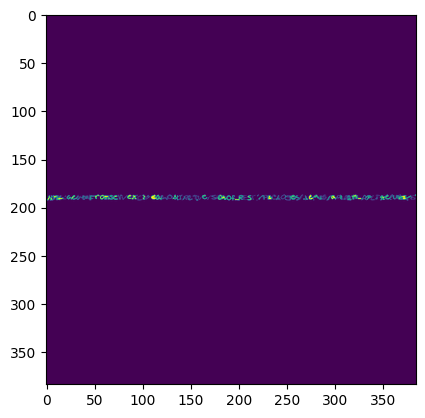

iter:   0%|          | 34/25241 [01:10<14:33:48,  2.08s/it]

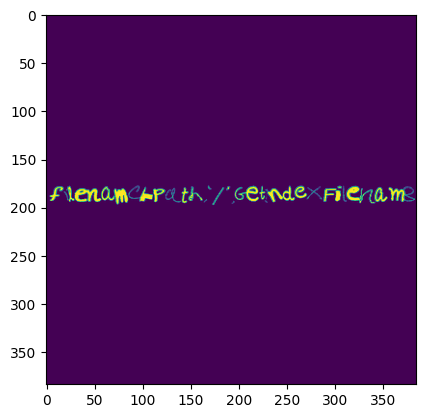

iter:   0%|          | 35/25241 [01:12<14:33:12,  2.08s/it]

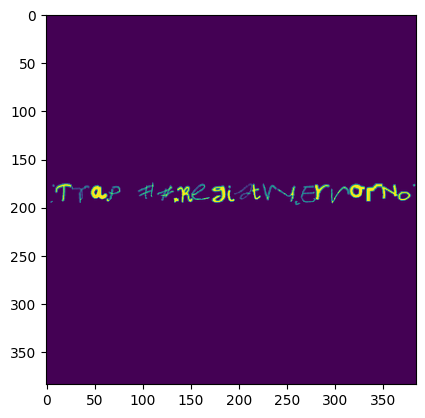

iter:   0%|          | 36/25241 [01:14<14:32:25,  2.08s/it]

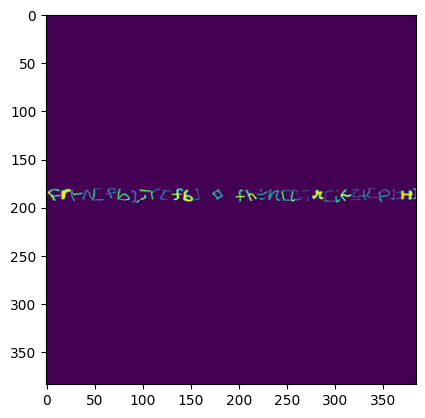

iter:   0%|          | 37/25241 [01:16<14:32:42,  2.08s/it]

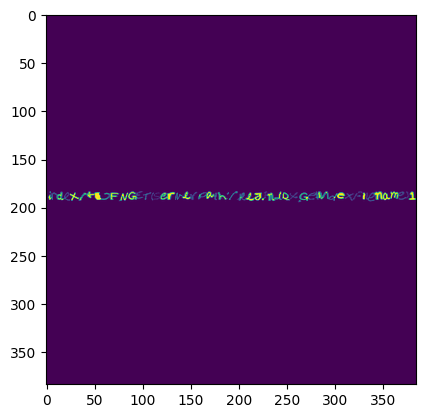

iter:   0%|          | 38/25241 [01:19<14:33:03,  2.08s/it]

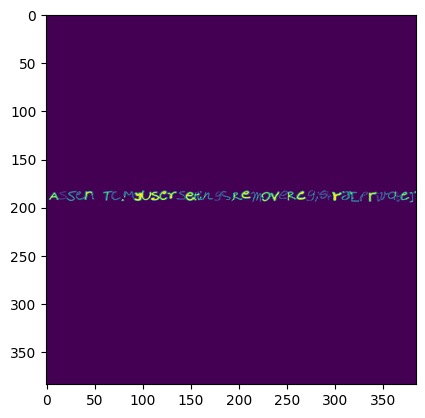

iter:   0%|          | 39/25241 [01:21<14:33:10,  2.08s/it]

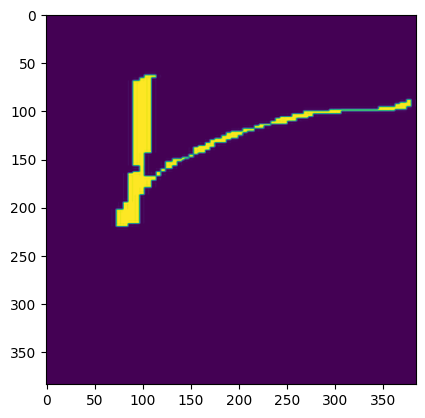

iter:   0%|          | 40/25241 [01:23<14:31:46,  2.08s/it]

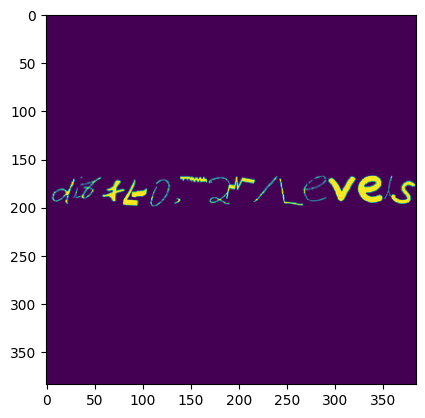

iter:   0%|          | 41/25241 [01:25<14:31:21,  2.07s/it]

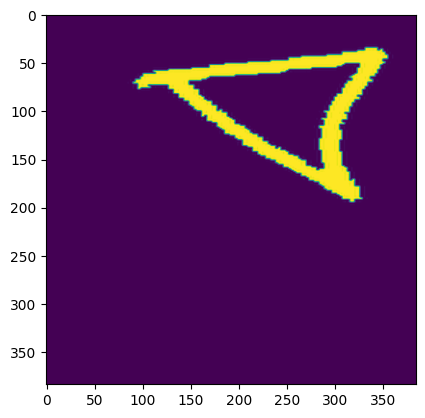

iter:   0%|          | 42/25241 [01:27<14:30:37,  2.07s/it]

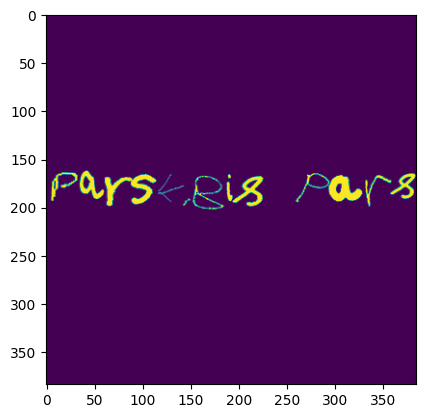

iter:   0%|          | 43/25241 [01:29<14:30:14,  2.07s/it]

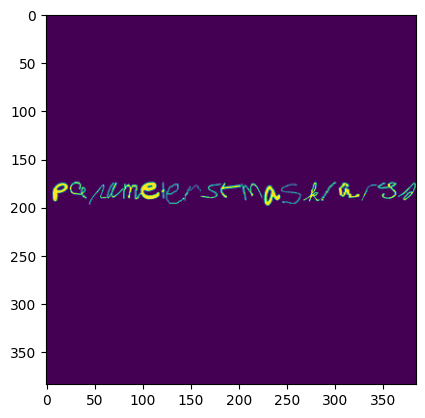

iter:   0%|          | 44/25241 [01:31<14:30:30,  2.07s/it]

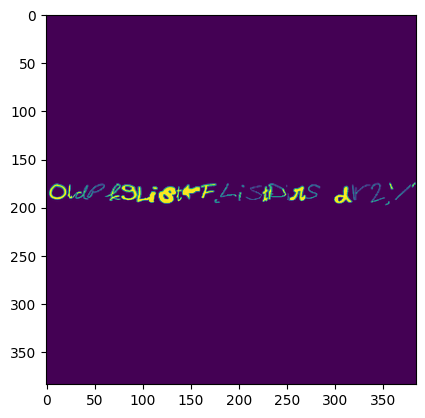

iter:   0%|          | 45/25241 [01:33<14:30:34,  2.07s/it]

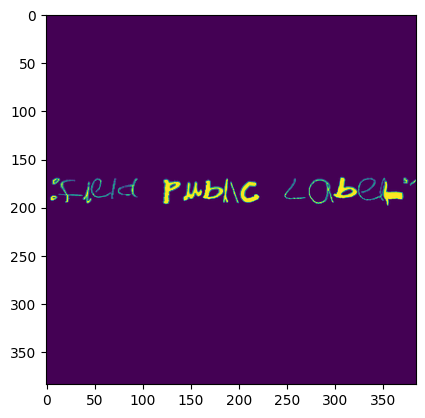

iter:   0%|          | 46/25241 [01:35<14:30:14,  2.07s/it]

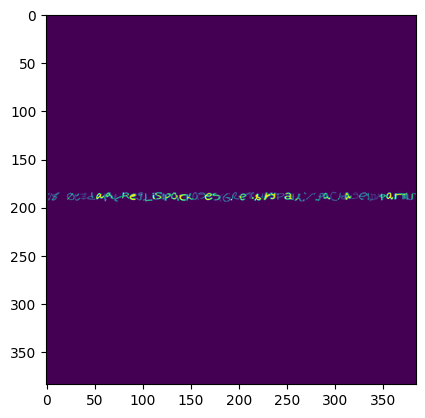

iter:   0%|          | 47/25241 [01:37<14:31:38,  2.08s/it]

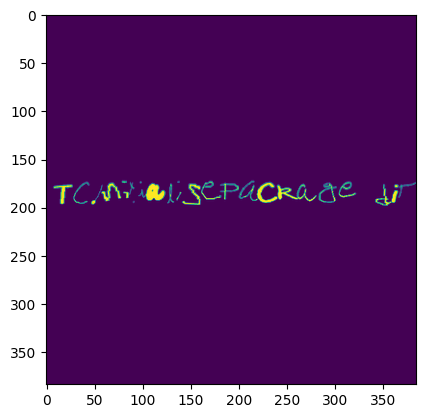

iter:   0%|          | 48/25241 [01:39<14:31:07,  2.07s/it]

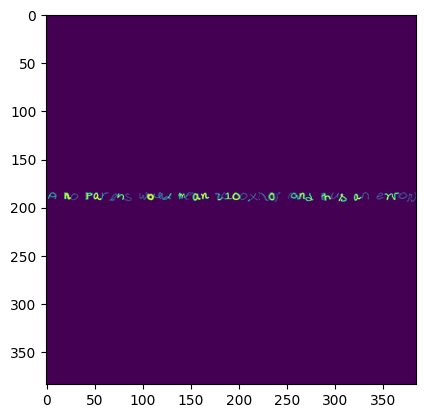

iter:   0%|          | 49/25241 [01:41<14:32:09,  2.08s/it]

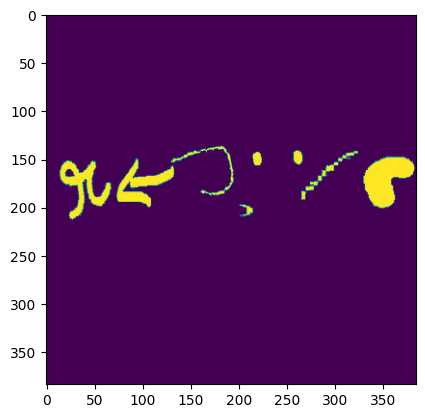

iter:   0%|          | 50/25241 [01:43<14:30:48,  2.07s/it]

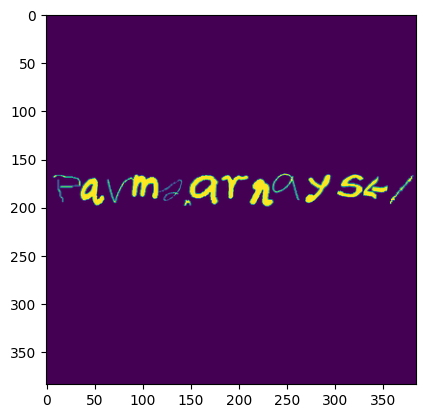

iter:   0%|          | 51/25241 [01:46<14:30:26,  2.07s/it]

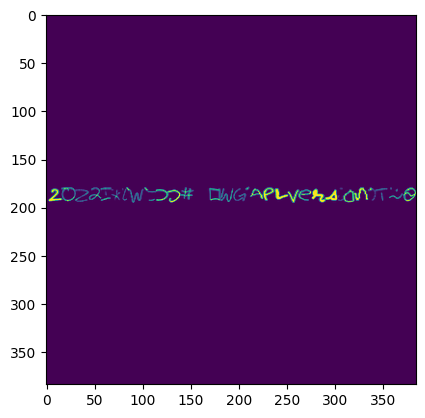

iter:   0%|          | 52/25241 [01:48<14:30:30,  2.07s/it]

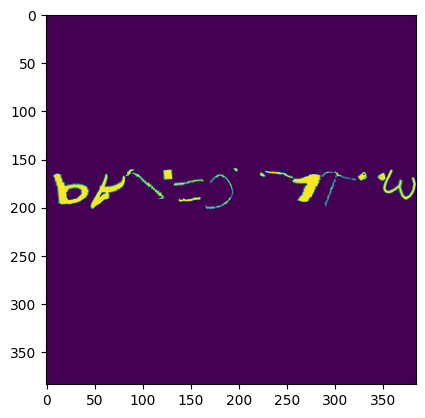

iter:   0%|          | 53/25241 [01:50<14:30:00,  2.07s/it]

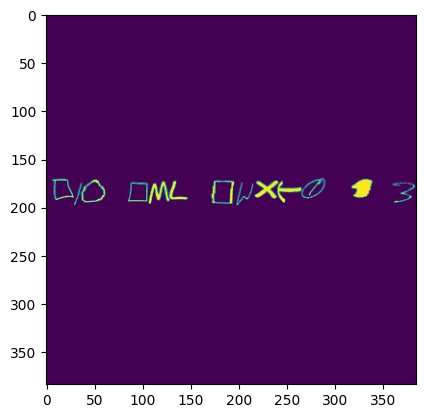

iter:   0%|          | 54/25241 [01:52<14:29:48,  2.07s/it]

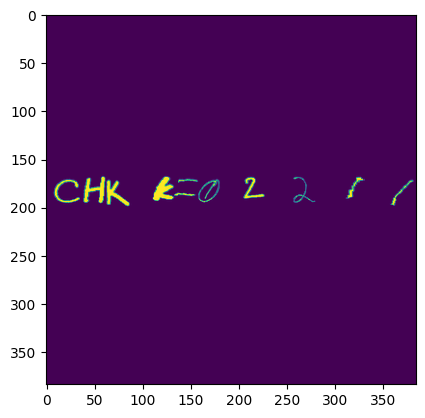

iter:   0%|          | 55/25241 [01:54<14:29:43,  2.07s/it]

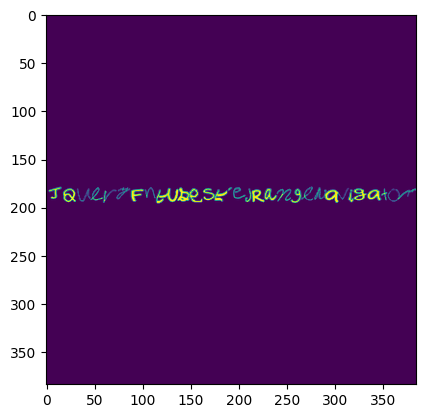

iter:   0%|          | 56/25241 [01:56<14:30:05,  2.07s/it]

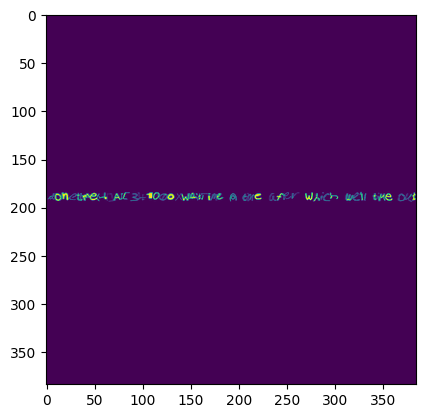

iter:   0%|          | 56/25241 [01:58<14:47:00,  2.11s/it]


KeyboardInterrupt: 

In [12]:
shape_set: set = set([])
import time
for x,y in tqdm(train_dataset, "iter", len(train_dataloader)):
    plt.imshow(x[ 0, :, :])
    plt.show()
    time.sleep(2)

In [ ]:
shape_set

set()